# Neural Network that can predict the system's health based on the radar signal strength

### using the sensor reading and system states data

In [1]:
import numpy as np
import pandas as pd

sensorData = pd.read_csv("sensor_readings_train.csv")
statesData = pd.read_csv("system_states_train.csv")

In [2]:
sensorData.head()

,timestamp,radar_signal_strength,sonar_distance,infrared_temperature
0,2024-01-01 00:00:00,86.944712,119.124879,35.237266
1,2024-01-01 00:00:01,82.572703,116.702561,35.249569
2,2024-01-01 00:00:02,89.724357,105.662210,35.265396
3,2024-01-01 00:00:03,86.207580,93.410376,35.745051
4,2024-01-01 00:00:04,84.720439,83.377757,36.063037


In [3]:
statesData.head()

,timestamp,power_level,system_health,operational_mode,cpu_usage,memory_usage
0,2024-01-01 00:00:00,100.106212,Good,Active,47.856711,70.678221
1,2024-01-01 00:00:01,103.040322,Good,Active,44.439096,69.620416
2,2024-01-01 00:00:02,101.267500,Good,Active,50.669275,71.204449
3,2024-01-01 00:00:03,99.114888,Good,Active,53.315804,70.528710
4,2024-01-01 00:00:04,100.161593,Good,Maintenance,54.827924,68.724997


In [7]:
sensorData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              3000 non-null   object 
 1   radar_signal_strength  3000 non-null   float64
 2   sonar_distance         3000 non-null   float64
 3   infrared_temperature   3000 non-null   float64
dtypes: float64(3), object(1)
memory usage: 93.9+ KB


In [9]:
statesData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   timestamp         3000 non-null   object 
 1   power_level       3000 non-null   float64
 2   system_health     3000 non-null   object 
 3   operational_mode  3000 non-null   object 
 4   cpu_usage         3000 non-null   float64
 5   memory_usage      3000 non-null   float64
dtypes: float64(3), object(3)
memory usage: 140.8+ KB


From the information above, I can see there is no missing data that needs to be dealt with.

In [12]:
sensorData.describe()

,radar_signal_strength,sonar_distance,infrared_temperature
count,3000.000000,3000.000000,3000.000000
mean,85.333194,100.130548,34.992183
std,7.359520,14.221334,1.658285
min,68.902682,77.326294,31.016133
25%,78.593616,85.880197,33.722358
50%,85.661508,100.277029,35.021215
75%,92.068625,114.149919,36.236785
max,100.502014,122.354631,39.042099


In [14]:
statesData.describe()

,power_level,cpu_usage,memory_usage
count,3000.000000,3000.000000,3000.000000
mean,95.015840,50.246610,69.988894
std,3.068990,8.807341,4.639211
min,87.371427,24.441615,56.869583
25%,92.558788,43.423638,66.590438
50%,95.034685,50.266655,69.969872
75%,97.532798,57.035214,73.437167
max,103.040322,77.013407,82.595776


In [16]:
#select intended fields from each csv and merge data
sensorData_selected = sensorData[['timestamp', 'radar_signal_strength', 'sonar_distance', 'infrared_temperature']]
statesData_selected = statesData[['timestamp', 'system_health']]
combinedData = pd.merge(sensorData_selected, statesData_selected, on='timestamp', how='inner')
combinedData.to_csv("combined_data.csv", index=False)
combinedData.head()

,timestamp,radar_signal_strength,sonar_distance,infrared_temperature,system_health
0,2024-01-01 00:00:00,86.944712,119.124879,35.237266,Good
1,2024-01-01 00:00:01,82.572703,116.702561,35.249569,Good
2,2024-01-01 00:00:02,89.724357,105.662210,35.265396,Good
3,2024-01-01 00:00:03,86.207580,93.410376,35.745051,Good
4,2024-01-01 00:00:04,84.720439,83.377757,36.063037,Good


In [18]:
#scale numerical columns: mean=0 and std=1
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  
combinedData[['radar_signal_strength', 'sonar_distance', 'infrared_temperature']] = scaler.fit_transform(combinedData[['radar_signal_strength', 'sonar_distance', 'infrared_temperature']])
combinedData.describe()

,radar_signal_strength,sonar_distance,infrared_temperature
count,3.000000e+03,3.000000e+03,3.000000e+03
mean,-4.310626e-16,1.610564e-16,2.651509e-15
std,1.000167e+00,1.000167e+00,1.000167e+00
min,-2.232924e+00,-1.603792e+00,-2.398087e+00
25%,-9.159159e-01,-1.002207e+00,-7.658737e-01
50%,4.461827e-02,1.030185e-02,1.751017e-02
75%,9.153523e-01,9.859629e-01,7.506610e-01
max,2.061459e+00,1.562989e+00,2.442639e+00


In [19]:
#use one hot encoding to transform system_health column to numerical data instead of categorical
# good = 2, fair = 1, poor =0
from tensorflow.keras.utils import to_categorical

combinedData['system_health'] = combinedData['system_health'].map({'Good': 2, 'Fair': 1, 'Poor': 0})
y = to_categorical(combinedData['system_health'])


In [20]:
#check to make sure the system_health column is now numerical
combinedData.head()

,timestamp,radar_signal_strength,sonar_distance,infrared_temperature,system_health
0,2024-01-01 00:00:00,0.219007,1.335845,0.147818,2
1,2024-01-01 00:00:01,-0.375154,1.165487,0.155238,2
2,2024-01-01 00:00:02,0.596764,0.389034,0.164784,2
3,2024-01-01 00:00:03,0.118830,-0.472620,0.454080,2
4,2024-01-01 00:00:04,-0.083274,-1.178201,0.645867,2


In [22]:
#check the datatype of the system_health column
combinedData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              3000 non-null   object 
 1   radar_signal_strength  3000 non-null   float64
 2   sonar_distance         3000 non-null   float64
 3   infrared_temperature   3000 non-null   float64
 4   system_health          3000 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 117.3+ KB


In [26]:
from sklearn.model_selection import train_test_split

X = combinedData[['radar_signal_strength', 'sonar_distance', 'infrared_temperature']].values
y = combinedData['system_health'].values  # target variable

# Split into training (70%), temporary set (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
# split temporary set into 15% test and 15% validation
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [96]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define the MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 10),  # Two hidden layers: 10 and 10 nodes
                    activation='relu',          
                    solver='adam',              
                    max_iter=2000,               
                    random_state=42)

# Train the model
mlp.fit(X_train, y_train)


MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=2000, random_state=42)

In [99]:
# Predict on validation and test sets
y_val_pred = mlp.predict(X_val)
y_test_pred = mlp.predict(X_test)

# Accuracy scores
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['Poor', 'Fair', 'Good']))


Validation Accuracy: 0.90
Test Accuracy: 0.90
Classification Report (Test Set):
              precision    recall  f1-score   support

        Poor       0.00      0.00      0.00        11
        Fair       0.00      0.00      0.00        36
        Good       0.90      1.00      0.94       403

    accuracy                           0.90       450
   macro avg       0.30      0.33      0.31       450
weighted avg       0.80      0.90      0.85       450



C:\Users\ashle\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ashle\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ashle\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


There were no predictions made for poor or fair. This is most likely because of unbalanced distribution.

In [102]:
#check distribution
unique, counts = np.unique(y_train, return_counts=True)
print("Class Distribution in Training Set:", dict(zip(unique, counts)))


Class Distribution in Training Set: {0: 28, 1: 168, 2: 1904}


As you can see, the amount of 'good' in the training set largely outweighs the other two categories. I found that using SMOTE, synthetic minority oversampling technique can help in this situation. 
Here is the link that I first found about SMOTE: https://www.geeksforgeeks.org/smote-for-imbalanced-classification-with-python/. 

In [105]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the new class distribution
unique, counts = np.unique(y_train_balanced, return_counts=True)
print("Class Distribution After SMOTE:", dict(zip(unique, counts)))


Class Distribution After SMOTE: {0: 1904, 1: 1904, 2: 1904}


In [107]:
# Create the MLPClassifier again
mlp = MLPClassifier(hidden_layer_sizes=(10, 10),
                    activation='relu',
                    solver='adam',
                    max_iter=2000,
                    random_state=42)

# Train the model with the balanced data
mlp.fit(X_train_balanced, y_train_balanced)


MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=2000, random_state=42)

In [109]:
# Predict on the validation and test sets
y_val_pred = mlp.predict(X_val)
y_test_pred = mlp.predict(X_test)

# Calculate accuracy scores
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

# Display classification report
from sklearn.metrics import classification_report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_test_pred, target_names=['Poor', 'Fair', 'Good']))


Validation Accuracy: 0.36
Test Accuracy: 0.40
Classification Report (Test Set):
              precision    recall  f1-score   support

        Poor       0.03      0.27      0.05        11
        Fair       0.06      0.28      0.10        36
        Good       0.91      0.42      0.57       403

    accuracy                           0.40       450
   macro avg       0.33      0.32      0.24       450
weighted avg       0.82      0.40      0.52       450



The neural network seems to be predicting the 'Good' results much better than the poor or fair. 

In [114]:
# run it over different alphas to try to improve accuracy
alpha_values = [0.0001, 0.001, 0.01, 0.1, 1]

for alpha in alpha_values:
    print(f"Training MLPClassifier with alpha={alpha}")

    mlp = MLPClassifier(
        hidden_layer_sizes=(10, 10),  
        activation='relu',
        solver='adam',
        alpha=alpha, 
        max_iter=2000,
        random_state=42
    )
    
    mlp.fit(X_train_balanced, y_train_balanced)
    train_accuracy = mlp.score(X_train_balanced, y_train_balanced)
    test_accuracy = mlp.score(X_test, y_test)
    
    print(f"Alpha: {alpha}, Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print("-" * 50)

Training MLPClassifier with alpha=0.0001
Alpha: 0.0001, Training Accuracy: 0.6206, Test Accuracy: 0.4022
--------------------------------------------------
Training MLPClassifier with alpha=0.001
Alpha: 0.001, Training Accuracy: 0.6210, Test Accuracy: 0.4044
--------------------------------------------------
Training MLPClassifier with alpha=0.01
Alpha: 0.01, Training Accuracy: 0.6313, Test Accuracy: 0.3933
--------------------------------------------------
Training MLPClassifier with alpha=0.1
Alpha: 0.1, Training Accuracy: 0.5830, Test Accuracy: 0.3933
--------------------------------------------------
Training MLPClassifier with alpha=1
Alpha: 1, Training Accuracy: 0.5641, Test Accuracy: 0.2711
--------------------------------------------------


In [116]:
# testing even smaller alphas
alpha_values = [0.0001, 0.00001, 0.000001, 0.0000001]

for alpha in alpha_values:
    print(f"Training MLPClassifier with alpha={alpha}")

    mlp = MLPClassifier(
        hidden_layer_sizes=(10, 10),  
        activation='relu',
        solver='adam',
        alpha=alpha, 
        max_iter=2000,
        random_state=42
    )
    
    mlp.fit(X_train_balanced, y_train_balanced)
    train_accuracy = mlp.score(X_train_balanced, y_train_balanced)
    test_accuracy = mlp.score(X_test, y_test)
    
    print(f"Alpha: {alpha}, Training Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print("-" * 50)

Training MLPClassifier with alpha=0.0001
Alpha: 0.0001, Training Accuracy: 0.6206, Test Accuracy: 0.4022
--------------------------------------------------
Training MLPClassifier with alpha=1e-05
Alpha: 1e-05, Training Accuracy: 0.6171, Test Accuracy: 0.3911
--------------------------------------------------
Training MLPClassifier with alpha=1e-06
Alpha: 1e-06, Training Accuracy: 0.6206, Test Accuracy: 0.3978
--------------------------------------------------
Training MLPClassifier with alpha=1e-07
Alpha: 1e-07, Training Accuracy: 0.6182, Test Accuracy: 0.3667
--------------------------------------------------


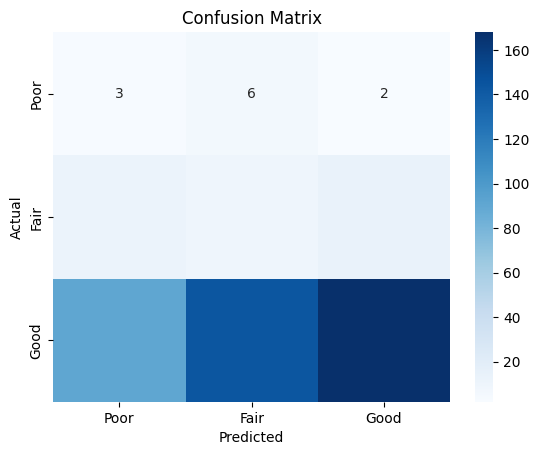

In [129]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(y_test, y_test_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Poor', 'Fair', 'Good'], yticklabels=['Poor', 'Fair', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


The graph above shows how well my network predicted the results. It shows that the model is pretty good at accurately predicting 'Good' but not very accurate at predicted fair or poor. This could be due to the class imbalance seen earlier. It also could be due to the features not having a strong enough effect on the system health. 

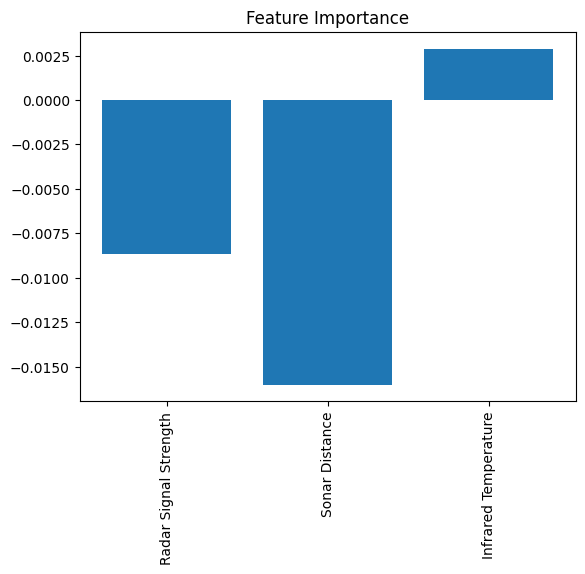

In [26]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
result = permutation_importance(mlp, X_test, y_test, n_repeats=10, random_state=42)

# Plot feature importance
plt.bar(range(X.shape[1]), result.importances_mean)
plt.xticks(range(X.shape[1]), ['Radar Signal Strength', 'Sonar Distance', 'Infrared Temperature'], rotation=90)
plt.title('Feature Importance')
plt.show()


The graph above shows that the sonar distance is by far the most important in predicting system health. This is followed by radar signal strength then infrared temperature at the least important. The negative values means that the sonar distance and radar strength both show negative impacts on the system health. 